In [22]:
# 1. Setup & imports
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import re
import matplotlib.pyplot as plt

In [23]:
nlp = spacy.load('en_core_web_sm')

In [24]:
df = pd.read_csv(r'C:\Users\Kaleb\OneDrive\Desktop\fintech-review-analysis\fintech-review-analysis\processed_data\reviews_with_ensemble_sentiment.csv')


In [25]:
# 3. Preprocessing function: tokenize, remove stopwords, lemmatize
def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

df['clean_text'] = df['review_text'].apply(preprocess_text)

In [26]:
# 4. TF-IDF keyword extraction per bank
def extract_keywords_by_bank(df, bank_name, max_features=50, ngram_range=(1,2)):
    bank_texts = df[df['bank_name'] == bank_name]['clean_text']
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    tfidf_matrix = vectorizer.fit_transform(bank_texts)
    keywords = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    keyword_scores = dict(zip(keywords, scores))
    sorted_keywords = sorted(keyword_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_keywords

In [27]:
# Extract keywords for each bank
banks = df['bank_name'].unique()
bank_keywords = {bank: extract_keywords_by_bank(df, bank) for bank in banks}

In [ ]:
# 5. Define manual theme keyword clusters (example)
# Documenting grouping logic here

theme_keywords = {
    'Account Access Issues': ['login', 'crash', 'access', 'password', 'error', 'fail','crush','አይከፍትም','incorrect','not','worst','not work','doesn'],
    'Transaction Performance': ['slow', 'transfer', 'payment', 'delay', 'transaction', 'fail','poor','መሻሻል'],
    'User Interface & Experience': ['ui', 'interface', 'design', 'loading', 'freeze', 'bug','bad','wor'],
    'Customer Support': ['support', 'service', 'response', 'help', 'contact', 'response'],
    'Feature Requests': ['update', 'feature', 'add', 'improve', 'request', 'option']
}

In [29]:
# 6. Assign theme(s) to each review based on keyword presence
def assign_themes(text):
    themes_found = []
    for theme, keywords in theme_keywords.items():
        for kw in keywords:
            # Use word boundaries for exact match to avoid partial matches
            if re.search(r'\b' + re.escape(kw) + r'\b', text):
                themes_found.append(theme)
                break
    if not themes_found:
        return 'Other'
    return ', '.join(themes_found)

df['themes'] = df['clean_text'].apply(assign_themes)

In [30]:
# 7. Save output CSV with themes
output_path = r'C:\Users\Kaleb\OneDrive\Desktop\fintech-review-analysis\fintech-review-analysis\processed_data\reviews_with_themes.csv'
df.to_csv(output_path, index=False)

In [31]:
# 8. Print 3+ themes examples per bank
for bank in banks:
    print(f"\n--- Themes for {bank} ---")
    bank_reviews = df[df['bank_name'] == bank]
    for theme in theme_keywords.keys():
        examples = bank_reviews[bank_reviews['themes'].str.contains(theme)].head(3)['review_text'].values
        print(f"\nTheme: {theme}")
        for ex in examples:
            print(f" - {ex}")


--- Themes for Bank of Abyssinia ---

Theme: Account Access Issues
 - Hello, I’m facing a problem with the BOA Mobile app. Every time I enter my phone number and password, the app crashes and shows an error that says “BoaMobile closed because this app has a bug.” I tried updating, reinstalling, and clearing cache, but nothing worked. Please fix this bug in the next update. I really need access to my account. Thank you.
 - the app crush frequently
 - This app is a joke. It crashes more than it works, takes forever to load, and half the features are just decorative at this point. Can’t log in, can’t transfer money, can’t even check my balance without it bugging out. To the developer: Are you actually trying to make this work, or is this some kind of social experiment to test our patience? Did you build this in your sleep? Because it definitely looks like it. If this is your idea of a functional app, maybe consider a different career path🙏

Theme: Transaction Performance
 - This app is a

C:\Users\Kaleb\AppData\Local\Temp\ipykernel_26976\2634621626.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=theme_counts.values, y=theme_counts.index, palette='viridis')
C:\Users\Kaleb\AppData\Local\Temp\ipykernel_26976\2634621626.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=theme_counts.values, y=theme_counts.index, palette='viridis')
C:\Users\Kaleb\AppData\Local\Temp\ipykernel_26976\2634621626.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=theme_counts.values, y=theme_counts.index, palette='viridis')


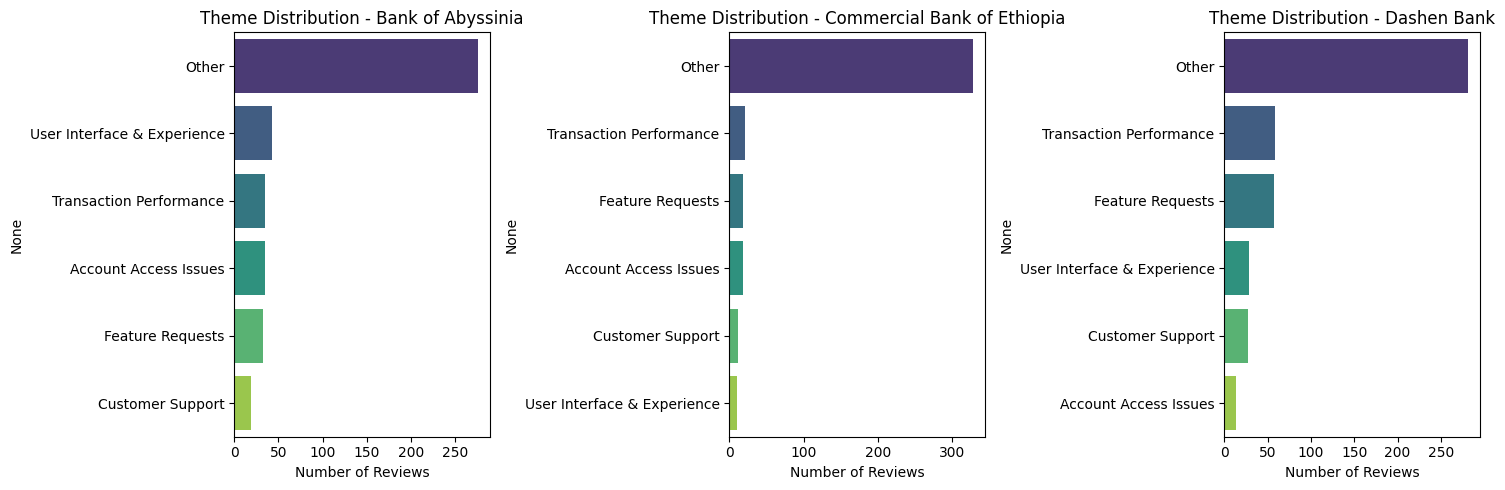

In [36]:
# a) Theme distribution per bank
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Now run the visualization code


plt.figure(figsize=(15,5))
for i, bank in enumerate(banks):
    plt.subplot(1, len(banks), i+1)
    theme_counts = df[df['bank_name'] == bank]['themes'].str.get_dummies(sep=', ').sum().sort_values(ascending=False)
    sns.barplot(x=theme_counts.values, y=theme_counts.index, palette='viridis')
    plt.title(f'Theme Distribution - {bank}')
    plt.xlabel('Number of Reviews')
plt.tight_layout()
plt.show()

In [33]:
print(f"Sentiment score coverage: {df['vader_compound'].notna().mean() * 100:.2f}%")


Sentiment score coverage: 100.00%
